In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv
/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv


In [2]:
import re
import nltk
import spacy
import gensim
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, FastText
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time


In [3]:
data = pd.read_csv('/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv')

In [4]:
data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [5]:
data.shape

(162980, 2)

In [6]:
data.category.value_counts()

category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64

In [7]:
# 0 Indicating it is a Neutral Tweet/Comment
# 1 Indicating a Postive Sentiment
# -1 Indicating a Negative Tweet/Comment

In [8]:
data = data[data['category']!= 0]

In [9]:
data.shape

(107767, 2)

In [20]:
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
data_text = data['clean_text'].dropna().tolist()

In [17]:
data_text = data_text[:1000]
len(data_text)

1000

In [21]:
stop_words = set(stopwords.words('english'))

clean_text = []
for sentence in data_text:
    sentence = re.sub(r'[^a-zA-Z ]', '', sentence.lower())  
    tokens = word_tokenize(sentence)
    lemmatized_tokens = [nlp(token)[0].lemma_ for token in tokens if token not in stop_words]
    clean_text.append(lemmatized_tokens)

In [22]:
clean_text[0:2]

[['modi',
  'promise',
  'minimum',
  'government',
  'maximum',
  'governance',
  'expect',
  'begin',
  'difficult',
  'job',
  'reform',
  'state',
  'take',
  'year',
  'get',
  'justice',
  'state',
  'business',
  'exit',
  'psus',
  'temple'],
 ['say',
  'vote',
  'modi',
  'welcome',
  'bjp',
  'tell',
  'rahul',
  'main',
  'campaigner',
  'modi',
  'think',
  'modi',
  'relax']]

In [15]:
glove_embeddings = {}
path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'
with open(path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector


In [16]:
pd.DataFrame(glove_embeddings)

,the,",",.,of,to,and,in,a,"""",'s,...,sigarms,katuna,aqm,1.3775,corythosaurus,chanty,kronik,rolonda,zsombor,sandberger
0,-0.038194,-0.107670,-0.339790,-0.15290,-0.189700,-0.071953,0.085703,-0.270860,-0.304570,0.588540,...,0.189170,-0.218870,0.373720,0.457710,0.083099,-0.155770,-0.094426,0.360880,-0.104610,0.283650
1,-0.244870,0.110530,0.209410,-0.24279,0.050024,0.231270,-0.222010,0.044006,-0.236450,-0.202500,...,-0.318100,-0.307850,0.212160,0.127100,-0.257510,-0.049188,0.147250,-0.169190,-0.504700,-0.626300
2,0.728120,0.598120,0.463480,0.89837,0.190840,0.023731,0.165690,-0.020260,0.175760,0.734790,...,-0.437490,-0.285570,-0.617470,-0.236760,-0.496520,-0.064377,-0.157390,-0.327040,-0.493310,-0.443510
3,-0.399610,-0.543610,-0.647920,0.16996,-0.049184,-0.506380,0.133730,-0.173950,-0.728540,-0.683380,...,0.612090,0.361860,0.481580,0.058859,0.163220,0.223600,0.071966,0.098332,0.135160,0.217700
4,0.083172,0.673960,-0.383770,0.53516,-0.089737,0.339230,0.382390,0.644400,-0.283430,-0.196750,...,-0.031357,-0.208920,-0.022374,0.175760,-0.224340,-0.201460,-0.298450,-0.429700,-0.363710,-0.087421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.510580,0.612140,0.318020,-0.34839,-0.415480,0.467420,0.792050,-0.285810,0.061104,0.064599,...,-0.246520,-0.079093,0.003589,-0.058495,0.037181,0.024318,-0.224490,-0.069396,0.095315,-0.085806
96,-0.520280,-0.351110,-0.392420,-0.56094,-0.038175,-0.499310,-0.206950,-0.010890,-0.390790,-0.375230,...,-0.104030,0.497520,0.056255,0.256980,-0.015981,-0.275870,0.257430,0.281600,0.150180,0.032651
97,-0.145900,-0.831550,-0.233940,-0.59100,-0.398040,-0.718950,-0.074273,-0.492300,-0.845570,-0.944750,...,0.328560,0.440100,0.035766,0.719170,-0.049755,0.075044,0.631430,0.271390,0.425270,0.436780
98,0.827800,0.452930,0.472980,1.00390,0.476470,0.868940,0.758080,0.636870,-0.035432,0.618020,...,-0.430730,-0.255090,-0.344050,-0.133310,-0.397680,-0.563800,-0.200900,-0.291880,-0.512500,-0.826070


In [17]:
# Word2Vec CBOW and Skip-gram
word2vec_cbow = Word2Vec(sentences=clean_text, vector_size=100, window=5, min_count=1, sg=0)
word2vec_sg = Word2Vec(sentences=clean_text, vector_size=100, window=5, min_count=1, sg=1)

# FastText
fast_text = FastText(sentences=clean_text, vector_size=100, window=5, min_count=1)


In [18]:
def embeddings_graph(model=None, title='', num_words=10, model_type='word2vec', glove_embeddings=None):
    """Visualizes word embeddings using PCA and t-SNE."""
    vectors = None  
    
    if model_type == 'word2vec' or model_type == 'fasttext':
        words = list(model.wv.index_to_key)[:num_words] 
        vectors = np.array([model.wv[word] for word in words])
    elif model_type == 'glove' and glove_embeddings is not None:
        words = list(glove_embeddings.keys())[:num_words]
        vectors = np.array([glove_embeddings[word] for word in words])

    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.7)
    for i, word in enumerate(words):
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]))
    plt.title(f'PCA Visualization of {title} Embeddings')
    plt.show()


In [19]:
def evaluate_cosine_similarity(model, word1, word2, model_type='word2vec', glove_embeddings=None):
    """Evaluates cosine similarity between two words using word embeddings."""
    if model_type == 'word2vec' or model_type == 'fasttext':
        vec1 = model.wv[word1]
        vec2 = model.wv[word2]
    elif model_type == 'glove' and glove_embeddings is not None:
        vec1 = glove_embeddings.get(word1)
        vec2 = glove_embeddings.get(word2)
        if vec1 is None or vec2 is None:
            print(f"One of the words ({word1} or {word2}) is not in the GloVe embeddings.")
            return None
    
    return cosine_similarity([vec1], [vec2])[0][0]

word1 = 'government'
word2 = 'india'

# cosine CBOW
similarity_word2vec_cbow = evaluate_cosine_similarity(word2vec_cbow, word1, word2, model_type='word2vec')
print(f"Cosine similarity between '{word1}' and '{word2}' in Word2Vec CBOW: {similarity_word2vec_cbow}")

# cosine Skip-gram
similarity_word2vec_sg = evaluate_cosine_similarity(word2vec_sg, word1, word2, model_type='word2vec')
print(f"Cosine similarity between '{word1}' and '{word2}' in Word2Vec Skip-gram: {similarity_word2vec_sg}")

# cosine FastText
similarity_fasttext = evaluate_cosine_similarity(fast_text, word1, word2, model_type='fasttext')
print(f"Cosine similarity between '{word1}' and '{word2}' in FastText: {similarity_fasttext}")

# cosine GloVe 
similarity_glove = evaluate_cosine_similarity(None, word1, word2, model_type='glove', glove_embeddings=glove_embeddings)
print(f"Cosine similarity between '{word1}' and '{word2}' in GloVe: {similarity_glove}")


Cosine similarity between 'government' and 'india' in Word2Vec CBOW: 0.9332473874092102
Cosine similarity between 'government' and 'india' in Word2Vec Skip-gram: 0.9979208707809448
Cosine similarity between 'government' and 'india' in FastText: 0.999951958656311
Cosine similarity between 'government' and 'india' in GloVe: 0.5369096994400024


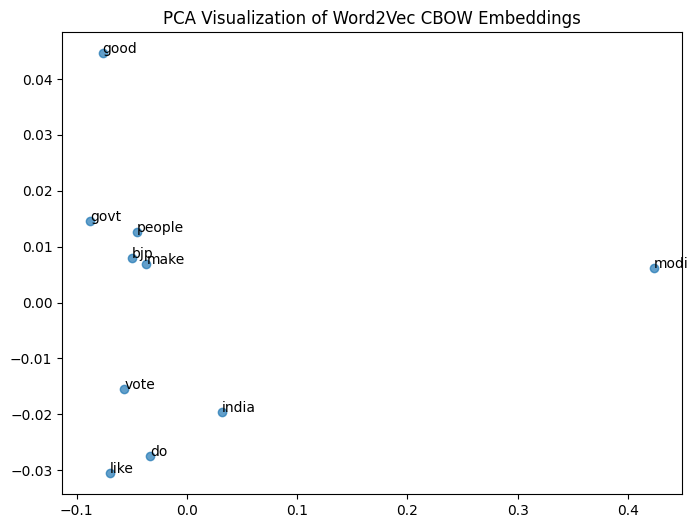

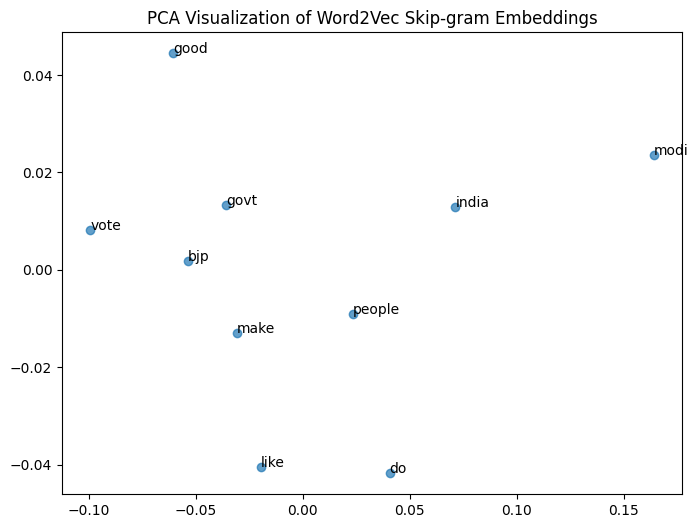

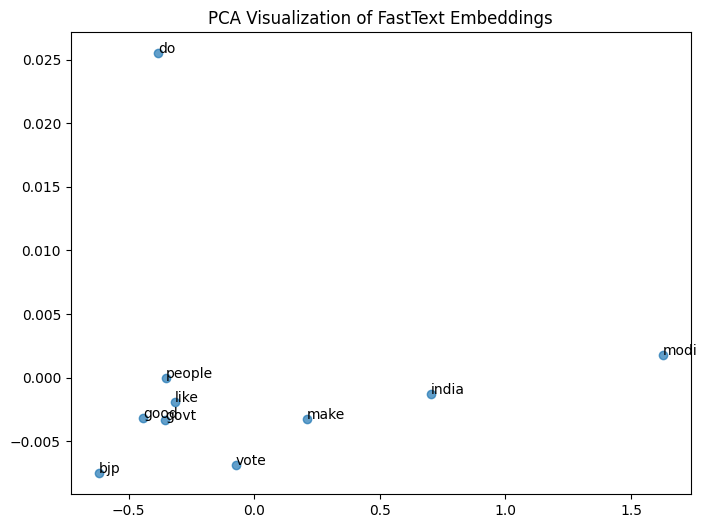

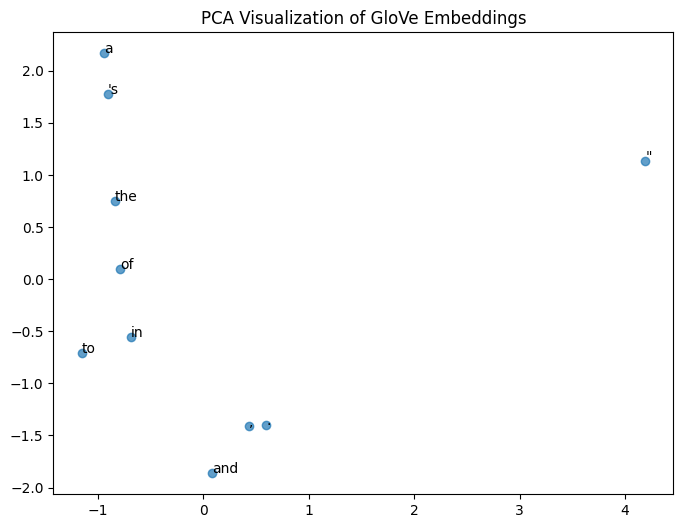

In [20]:
embeddings_graph(word2vec_cbow, "Word2Vec CBOW", num_words=10, model_type='word2vec')
embeddings_graph(word2vec_sg, "Word2Vec Skip-gram", num_words=10, model_type='word2vec')  # Corrected here
embeddings_graph(fast_text, "FastText", num_words=10, model_type='fasttext')
embeddings_graph(None, "GloVe", num_words=10, model_type='glove', glove_embeddings=glove_embeddings)

# TASK 2 RNN

In [21]:
data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
8,with upcoming election india saga going import...,1.0


In [29]:
data['clean_text'] = data['clean_text'].astype(str).fillna('')
comments = data['clean_text'].values
targets = data['category'].values
targets = (targets == 1).astype(int)  #-1,1 to 0,1

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)
X = pad_sequences(sequences, maxlen=100)
y = targets

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=100),
    tf.keras.layers.SimpleRNN(32, return_sequences=False),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
rnn_model = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


Epoch 1/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.7610 - loss: 0.4841 - val_accuracy: 0.9120 - val_loss: 0.2352
Epoch 2/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.9375 - loss: 0.1794 - val_accuracy: 0.9191 - val_loss: 0.2106
Epoch 3/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.9526 - loss: 0.1400 - val_accuracy: 0.9300 - val_loss: 0.1932
Epoch 4/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.9630 - loss: 0.1114 - val_accuracy: 0.9266 - val_loss: 0.2076
Epoch 5/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.9721 - loss: 0.0882 - val_accuracy: 0.9303 - val_loss: 0.2083
Epoch 6/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.9792 - loss: 0.0656 - val_accuracy: 0.9262 - val_loss: 0.2274
Epoch 7/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.9851 - loss: 0.0480 - val_accuracy: 0.9310 - val_loss: 0.2303
Epoch 8/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.9893 -

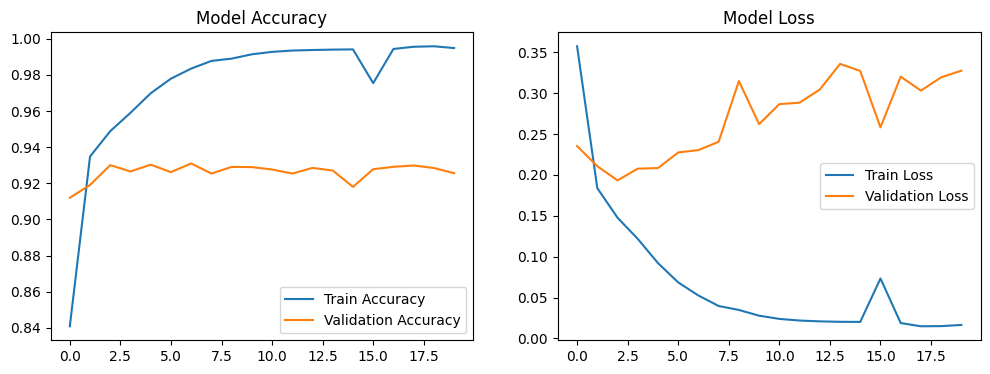

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rnn_model.history['accuracy'], label='Train Accuracy')
plt.plot(rnn_model.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(rnn_model.history['loss'], label='Train Loss')
plt.plot(rnn_model.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [27]:
def get_gradients(epoch, logs):
    with tf.GradientTape() as tape:
        y_pred = model(X_train[:100])  
        loss = tf.keras.losses.binary_crossentropy(tf.reshape(y_train[:100], (-1, 1)), y_pred)
    grads = tape.gradient(loss, model.trainable_variables)
    grads_norm = [tf.norm(g).numpy() for g in grads if g is not None]
    gradients.append(np.mean(grads_norm))


In [28]:
gradients = []
gradient_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=get_gradients)

model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[gradient_callback])

Epoch 1/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.9959 - loss: 0.0142
Epoch 2/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9972 - loss: 0.0107
Epoch 3/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.9969 - loss: 0.0107
Epoch 4/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.9970 - loss: 0.0108
Epoch 5/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9971 - loss: 0.0098
Epoch 6/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9968 - loss: 0.0118
Epoch 7/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9973 - loss: 0.0098
Epoch 8/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.9971 - loss: 0.0112
Epoch 9/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9980 - loss: 0.0080
Epoch 10/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9970 - loss: 0.0105
Epoch 11/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9968 - loss: 0.0120
Epoch 12/20

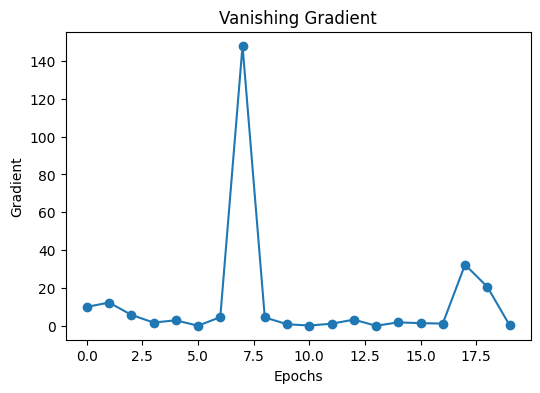

In [29]:
gradients = np.array(gradients)
plt.figure(figsize=(6, 4))
plt.plot(gradients, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Gradient')
plt.title('Vanishing Gradient')
plt.show()


# Task 3

LSTM

In [34]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=100),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [35]:
start_time = time.time()
lstm_res = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)
print("implementation of LSTM model", time.time() - start_time)

Epoch 1/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8239 - loss: 0.3787 - val_accuracy: 0.9417 - val_loss: 0.1588
Epoch 2/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9576 - loss: 0.1160 - val_accuracy: 0.9633 - val_loss: 0.0985
Epoch 3/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9783 - loss: 0.0631 - val_accuracy: 0.9627 - val_loss: 0.1055
Epoch 4/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9854 - loss: 0.0447 - val_accuracy: 0.9652 - val_loss: 0.1037
Epoch 5/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9903 - loss: 0.0319 - val_accuracy: 0.9582 - val_loss: 0.1314
Epoch 6/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9925 - loss: 0.0243 - val_accuracy: 0.9607 - val_loss: 0.1405
Epoch 7/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9938 - loss: 0.0199 - val_accuracy: 0.9568 - val_loss: 0.1654
Epoch 8/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9953 - loss: 0

GRU

In [32]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=100),
    tf.keras.layers.GRU(32, return_sequences=False),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [33]:
start_time = time.time()
gru_res = model_gru.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)
print("implementation of GRU model", time.time() - start_time)

Epoch 1/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8215 - loss: 0.3821 - val_accuracy: 0.9458 - val_loss: 0.1467
Epoch 2/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9627 - loss: 0.1065 - val_accuracy: 0.9605 - val_loss: 0.1052
Epoch 3/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9779 - loss: 0.0664 - val_accuracy: 0.9650 - val_loss: 0.0994
Epoch 4/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9851 - loss: 0.0481 - val_accuracy: 0.9625 - val_loss: 0.1085
Epoch 5/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9893 - loss: 0.0360 - val_accuracy: 0.9589 - val_loss: 0.1288
Epoch 6/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9918 - loss: 0.0276 - val_accuracy: 0.9595 - val_loss: 0.1322
Epoch 7/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9946 - loss: 0.0196 - val_accuracy: 0.9575 - val_loss: 0.1473
Epoch 8/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9953 - loss: 0

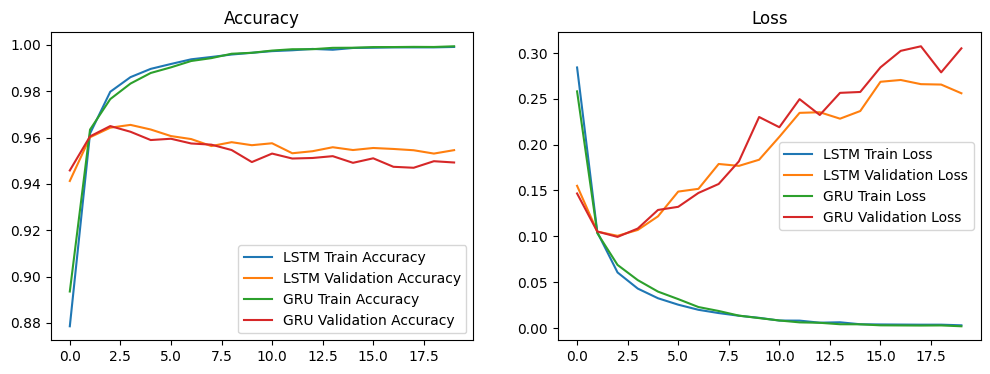

In [34]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(lstm_res.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(lstm_res.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.plot(gru_res.history['accuracy'], label='GRU Train Accuracy')
plt.plot(gru_res.history['val_accuracy'], label='GRU Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(lstm_res.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_res.history['val_loss'], label='LSTM Validation Loss')
plt.plot(gru_res.history['loss'], label='GRU Train Loss')
plt.plot(gru_res.history['val_loss'], label='GRU Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

# Task 4

In [9]:
sampled_texts = data['clean_text'].sample(n=50, random_state=42).values  # Ensures reproducibility
sampled_texts[0:2]

array(['listen how modi changing the minds muslims india modi will thanks ',
       'chawkidar chor trap shit will not get any government job will not get any bank loan will face enquiry after elections for defaming modi get ready for very big trouble congress leaders cant help from tihar jail haha '],
      dtype=object)

In [10]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sampled_texts)
total_words = len(tokenizer.word_index) + 1  

In [11]:
sequence_data = []
for text in sampled_texts:
    words = text.split()
    for i in range(1, len(words)):
        sequence_data.append(words[:i+1])

# sequences to numbers
sequences = tokenizer.texts_to_sequences([" ".join(seq) for seq in sequence_data])


In [12]:
sequences = [seq for seq in sequences if len(seq) > 1]


max_sequence_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='pre')

X_textgen, y_textgen = sequences[:, :-1], sequences[:, -1]

y_textgen = tf.keras.utils.to_categorical(y_textgen, num_classes=total_words)

In [14]:
textgen_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_sequence_length - 1),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(len(tokenizer.word_index) + 1, activation='softmax')
])

textgen_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:
textgen_model.fit(X_textgen, y_textgen, epochs=100, batch_size=64)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0478 - loss: 6.0093
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0373 - loss: 6.0042 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0472 - loss: 5.8798
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0288 - loss: 5.8234 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0366 - loss: 5.7986 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0423 - loss: 5.6565
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0393 - loss: 5.5460
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0428 - loss: 5.4434
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0421 - loss: 5.3119
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0432 - loss: 5.1865
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0488 - loss: 5.0654
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accur

In [25]:
clean_text[3:5]

[['answer',
  'among',
  'powerful',
  'world',
  'leader',
  'today',
  'trump',
  'putin',
  'modi',
  'may'],
 ['upcoming',
  'election',
  'india',
  'saga',
  'go',
  'important',
  'pair',
  'look',
  'current',
  'modi',
  'lead',
  'govt',
  'elect',
  'deal',
  'brexit',
  'combination',
  'weekly',
  'look',
  'juicy',
  'bear',
  'imho']]

In [26]:
seed_texts = ["combination", "india", "trump"]

n_words = 20

for seed_text in seed_texts:
    print('input words', seed_text)
    
    for _ in range(n_words):  
        tokenized_input = tokenizer.texts_to_sequences([seed_text])[0]
        tokenized_input = pad_sequences([tokenized_input], maxlen=max_sequence_length - 1, padding='pre')
        predicted_index = np.argmax(textgen_model.predict(tokenized_input), axis=-1)[0]
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        
        seed_text += " " + output_word  
    
    print('result text', seed_text)
    print("-")


input words combination
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
result text combination 2019 election nda govt takes overpeople will get hold all opposition party netas who abused armed forces modibjp and india
-
input words india
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━

# Task 5

In [27]:
model_bilstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [31]:
start_time = time.time()
bilstm_res = model_bilstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)
print('implementation of BI LSTM model',time.time() - start_time)


Epoch 1/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - accuracy: 0.8098 - loss: 0.4015 - val_accuracy: 0.9458 - val_loss: 0.1442
Epoch 2/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9656 - loss: 0.0992 - val_accuracy: 0.9637 - val_loss: 0.0965
Epoch 3/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9819 - loss: 0.0548 - val_accuracy: 0.9636 - val_loss: 0.1046
Epoch 4/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9870 - loss: 0.0413 - val_accuracy: 0.9657 - val_loss: 0.0997
Epoch 5/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9914 - loss: 0.0292 - val_accuracy: 0.9620 - val_loss: 0.1355
Epoch 6/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9927 - loss: 0.0238 - val_accuracy: 0.9614 - val_loss: 0.1279
Epoch 7/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9945 - loss: 0.0173 - val_accuracy: 0.9612 - val_loss: 0.1375
Epoch 8/20
2695/2695 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.9961 -

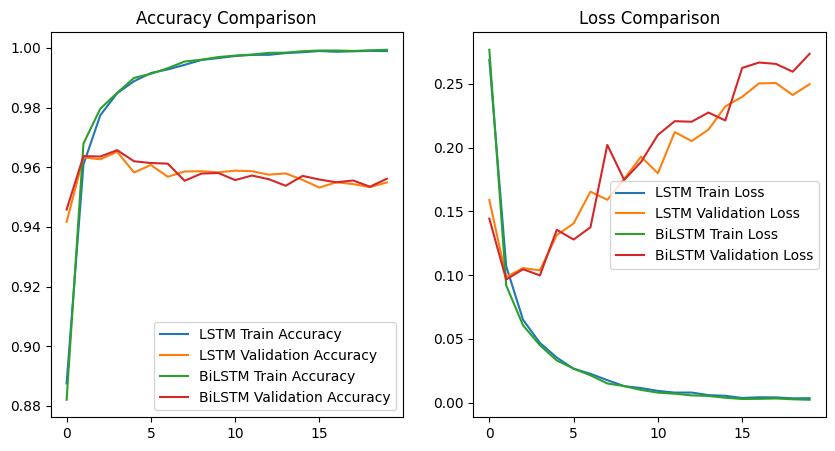

In [42]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_res.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(lstm_res.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.plot(bilstm_res.history['accuracy'], label='BiLSTM Train Accuracy')
plt.plot(bilstm_res.history['val_accuracy'], label='BiLSTM Validation Accuracy')
plt.legend()
plt.title('Accuracy Comparison')

plt.subplot(1, 2, 2)
plt.plot(lstm_res.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_res.history['val_loss'], label='LSTM Validation Loss')
plt.plot(bilstm_res.history['loss'], label='BiLSTM Train Loss')
plt.plot(bilstm_res.history['val_loss'], label='BiLSTM Validation Loss')
plt.legend()
plt.title('Loss Comparison')

plt.show()